In [21]:
import matplotlib as mpl
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from retrospective_analysis.metrics import max_error, mean_difference
from retrospective_analysis.data_loading import load_dataframe, moving_average, add_baselines
from retrospective_analysis.evaluate_scenarios import compute_metrics, compute_metrics_all_scenarios, evaluate_all_scenarios, evaluate_all_scenarios_with_dates

In [22]:
#to change with path suited for you

results_path = 'results/'
images_path = 'images/'

# divide by 100 to express as % of normalization
new_hosp_normalization = 3040/100 # based on data from Paireau et al. publication 
icu_normalization = 7000/100 
idf_icu_normalization  = 2600/100

metrics = {"MAE": mean_absolute_error, "ME": mean_difference,  
           "Max Error": max_error}

endpoints_normalizations = {"ICU": 7000/100, 
                            "idf_icu_normalization" : 2600/100,
                            "New hosp.": 3040/100}

data_location = {"2020/04/28 ICU": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2020_04_28_ICU_error.csv",
        "2020/10/30 ICU": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2020_10_30_ICU_error.csv",
        "2021/01/16": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_01_16_new_hosp_error.csv",
        "2021/02/02": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_02_02_new_hosp_error.csv",
        "2021/02/08": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_02_08_new_hosp_error.csv",
        "2021/02/23": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_02_23_new_hosp_error.csv",
        "2021/04/26": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_04_26_new_hosp_error.csv",
        "2021/05/21": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_05_21_new_hosp_error.csv",
        "2021/05/21 ICU": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2021_05_21_ICU_error.csv",
        "2021/07/26 ICU": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2021_07_26_ICU_error.csv",
        "2021/07/26": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_07_26_new_hosp_error.csv",
        "2021/08/05": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_08_05_new_hosp_error.csv",
        "2021/08/05 ICU": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2021_08_05_ICU_error.csv",
        "2021/10/04": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_10_04_new_hosp_error.csv",
        "2022/01/07": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2022_01_07_new_hosp_error.csv",
        "2022/01/07 ICU": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2022_01_07_ICU_error.csv"}

normalizations = {"2020/04/28 ICU": idf_icu_normalization,
        "2020/10/30 ICU": icu_normalization,
        "2021/01/16": new_hosp_normalization,
        "2021/02/02": new_hosp_normalization,
        "2021/02/08": new_hosp_normalization,
        "2021/02/23": new_hosp_normalization,
        "2021/04/26": new_hosp_normalization,
        "2021/05/21": new_hosp_normalization,
        "2021/05/21 ICU": icu_normalization,
        "2021/07/26 ICU": icu_normalization,
        "2021/07/26": new_hosp_normalization,
        "2021/08/05": new_hosp_normalization,
        "2021/08/05 ICU": icu_normalization,
        "2021/10/04": new_hosp_normalization,
        "2022/01/07": new_hosp_normalization,
        "2022/01/07 ICU": icu_normalization}

scenario_endpoints = ["ICU", "ICU", "New hosp.", "New hosp.", "New hosp.",
                      "New hosp.", "New hosp.", "New hosp.",
                      "ICU", "ICU", "New hosp.", "New hosp.", "ICU",  "New hosp.", "New hosp.","ICU"]


In [23]:
# Set matplotlib style 
mpl.use("pgf")
mpl.rcParams.update({
    'font.family': 'serif',
    'axes.titlesize' : 40,
    'axes.labelsize' : 40,
    'legend.fontsize' : 40,
    'pgf.rcfonts': False,
    'figure.dpi': 300.0,
})

mpl.rcParams['axes.unicode_minus'] = False
sns.set(font_scale=1.5, style="white", 
        rc={
            'font.family': 'sans-serif',
            'axes.titlesize' : 40,
            'axes.labelsize' : 40,
            'legend.fontsize' : 40,
            'xtick.labelsize' : 40,
            'ytick.labelsize' : 40,
            'xtick.bottom': True,
            'ytick.left': True,
            'figure.dpi': 300.0,
})

%matplotlib inline

In [24]:
results = evaluate_all_scenarios(data_location, metrics=metrics, normalizations=normalizations)
with open(results_path + 'global_evaluation.csv', 'w', encoding = 'utf-8-sig') as f:
  results.to_csv(f)
results

,Average uncertainty,Max uncertainty,Global accuracy,MAE (median),MAPE (median),MAPE (optimist),MAPE (pessimist)
Scenario: 2020/04/28 ICU ICU,20.1,88.3,13.3,7.0,43.2,17.8,166.9
Scenario: 2020/10/30 ICU ICU,47.9,101.3,40.0,19.0,35.0,15.2,96.5
Scenario: 2021/01/16 New hosp.,54.9,119.7,31.1,30.2,72.7,18.1,144.0
Scenario: 2021/02/02 New hosp.,37.2,78.3,0.0,27.7,67.3,24.1,115.2
Scenario: 2021/02/08 New hosp.,25.8,60.1,0.0,24.4,59.4,34.6,99.8
Scenario: 2021/02/23 New hosp.,21.3,55.5,51.9,13.5,31.8,40.1,21.5
Scenario: 2021/04/26 New hosp.,16.0,32.6,0.0,14.3,115.4,52.9,206.0
Scenario: 2021/05/21 New hosp.,5.1,10.3,54.2,2.0,17.9,43.0,40.1
Scenario: 2021/05/21 ICU ICU,3.8,8.7,0.0,6.9,20.9,27.8,14.9
Scenario: 2021/07/26 ICU ICU,67.0,142.0,7.8,32.7,138.0,30.7,307.5


In [25]:
results_with_dates = evaluate_all_scenarios_with_dates(data_location, metrics=metrics, normalizations=normalizations)
with open(results_path + 'global_evaluation_dates.csv', 'w', encoding = 'utf-8-sig') as f:
  results_with_dates.to_csv(f)
results_with_dates

,Scenario,Scenario type,Average uncertainty (beds),Max uncertainty,Global accuracy,"MAE (median, beds)",Period
"Scenario: 2020/04/28 ICU, period: 0 days - 14 days",2020/04/28 ICU,ICU,0.0,0.0,13.3,98.1,0 days - 14 days
"Scenario: 2020/04/28 ICU, period: 14 days - 28 days",2020/04/28 ICU,ICU,0.0,0.0,13.3,122.3,14 days - 28 days
"Scenario: 2020/04/28 ICU, period: 28 days - 42 days",2020/04/28 ICU,ICU,156.0,487.0,13.3,72.6,28 days - 42 days
"Scenario: 2020/04/28 ICU, period: 42 days - 56 days",2020/04/28 ICU,ICU,1441.4,2142.0,13.3,310.6,42 days - 56 days
"Scenario: 2020/10/30 ICU, period: 0 days - 14 days",2020/10/30 ICU,ICU,440.9,1202.0,40.0,815.2,0 days - 14 days
"Scenario: 2020/10/30 ICU, period: 14 days - 28 days",2020/10/30 ICU,ICU,2955.6,4531.0,40.0,1655.1,14 days - 28 days
"Scenario: 2020/10/30 ICU, period: 28 days - 42 days",2020/10/30 ICU,ICU,5881.1,6793.0,40.0,1563.9,28 days - 42 days
"Scenario: 2021/01/16, period: 0 days - 14 days",2021/01/16,New hosp.,319.9,573.3,31.1,129.1,0 days - 14 days
"Scenario: 2021/01/16, period: 14 days - 28 days",2021/01/16,New hosp.,1138.3,1862.7,31.1,241.2,14 days - 28 days
"Scenario: 2021/01/16, period: 28 days - 42 days",2021/01/16,New hosp.,2816.0,3638.6,31.1,960.3,28 days - 42 days


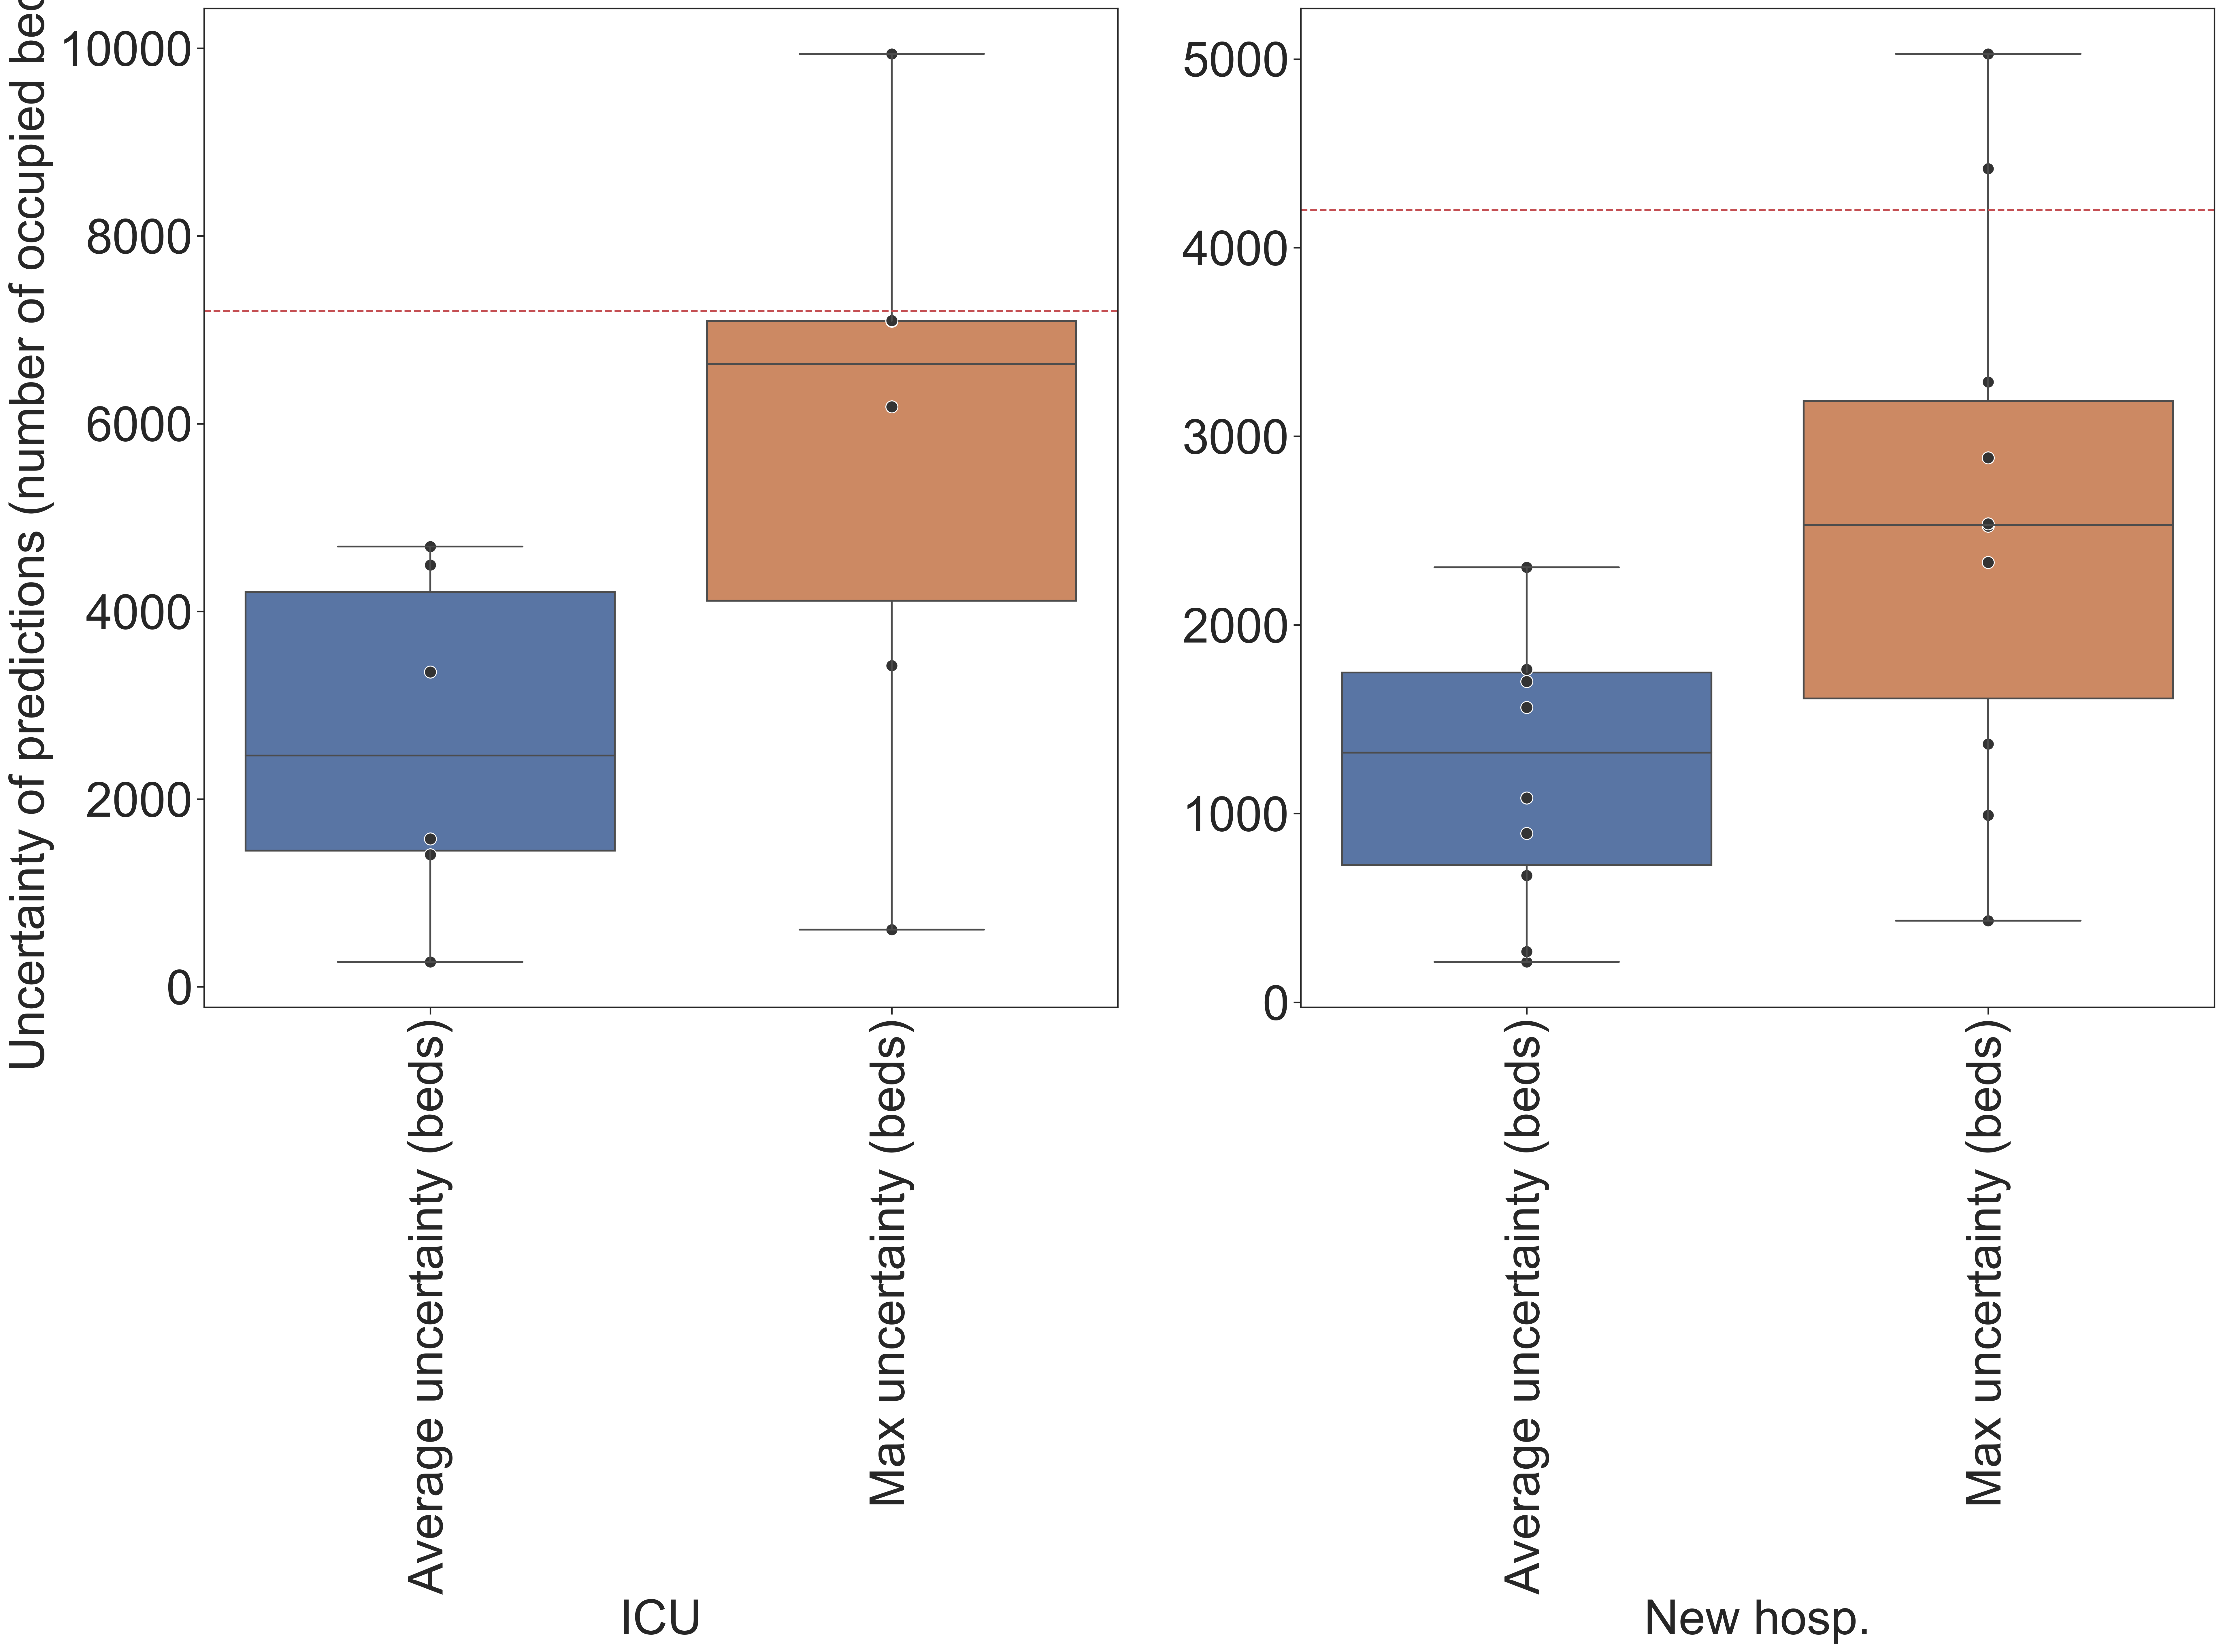

In [26]:
endpoints_normalizations = {"ICU": 7000/100, 
                            "New hosp.": 4200/100}

display_df = results.copy()
display_df["endpoints"] = scenario_endpoints
display_df["Average uncertainty (beds)"] = display_df["Average uncertainty"].values*np.array([endpoints_normalizations[x] for x in scenario_endpoints])
display_df["Max uncertainty (beds)"] = display_df["Max uncertainty"].values*np.array([endpoints_normalizations[x] for x in scenario_endpoints])

display_df = display_df.melt(id_vars='endpoints', value_vars=['Average uncertainty (beds)', "Max uncertainty (beds)"])

fig, axes = plt.subplots(figsize=(30, 15), ncols=2, nrows=1)

# x2 avec mean + x2 avec mae + mape

h1 = sns.boxplot(data=display_df[display_df.endpoints=='ICU'], y='value', x='variable', ax=axes[0])
sns.scatterplot(data=display_df[display_df.endpoints=='ICU'], y='value', x='variable', ax=axes[0], s=100, color=".2")
# = sns.boxplot(data=df_median_scenario, y="Max error (beds)", ax=ax, x='endpoints')
axes[0].set_xlabel("ICU")
axes[0].set_ylabel("Uncertainty of predictions (number of occupied beds)")
axes[0].axhline(7200, c='r', linestyle='--')
axes[0].tick_params(axis='x', rotation=90)

h2 = sns.boxplot(data=display_df[display_df.endpoints!='ICU'], y='value', x='variable', ax=axes[1])
sns.scatterplot(data=display_df[display_df.endpoints!='ICU'], y='value', x='variable', ax=axes[1], s=100, color=".2")

# = sns.boxplot(data=df_median_scenario, y="Max error (beds)", ax=ax, x='endpoints')
axes[1].set_xlabel("New hosp.")
axes[1].axhline(4200, c='r', linestyle='--')
axes[1].tick_params(axis='x', rotation=90)

plt.ylabel("")
    
fig_path = images_path + '/uncertainties_global.pdf'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

In [27]:
display_df = results_with_dates.copy()


fig, axes = plt.subplots(figsize=(30, 15), ncols=2, nrows=1)

# x2 avec mean + x2 avec mae + mape

h1 = sns.boxplot(data=display_df, y='Average uncertainty (beds)', x='Period', hue = "Scenario type",  ax=axes[0])
# = sns.boxplot(data=df_median_scenario, y="Max error (beds)", ax=ax, x='endpoints')
axes[0].set_xlabel("Uncertainty")
axes[0].set_ylabel("Average uncertainty (beds)")
axes[0].axhline(7200, c='r', linestyle='--')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(title='', loc=1)

h1 = sns.boxplot(data=display_df, y='MAE (median, beds)', x='Period', hue = "Scenario type",  ax=axes[1])
# = sns.boxplot(data=df_median_scenario, y="Max error (beds)", ax=ax, x='endpoints')
axes[1].set_xlabel("MAE")
axes[1].set_ylabel("MAE (median, beds)")
axes[1].axhline(4200, c='r', linestyle='--')
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(title='')

    
fig_path = images_path + '/time_evolution.pdf'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')

In [ ]:
normalizations = {"2020/04/28": icu_normalization,
        "2020/10/30": icu_normalization,
        "2021/01/16": new_hosp_normalization,
        "2021/02/02": new_hosp_normalization,
        "2021/02/08": new_hosp_normalization,
        "2021/02/23": new_hosp_normalization,
        "2021/04/26": new_hosp_normalization,
        "2021/05/21": new_hosp_normalization,
        "2021/07/26": icu_normalization,
        "2021/08/05": icu_normalization,
        "2021/10/04": icu_normalization,
        "2022/01/07": icu_normalization}

data_location = {"2020/04/28": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2020_04_28_ICU_error.csv",
        "2020/10/30": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2020_10_30_ICU_error.csv",
        "2021/01/16": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_01_16_new_hosp_error.csv",
        "2021/02/02": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_02_02_new_hosp_error.csv",
        "2021/02/08": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_02_08_new_hosp_error.csv",
        "2021/02/23": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_02_23_new_hosp_error.csv",
        "2021/04/26": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_04_26_new_hosp_error.csv",
        "2021/05/21": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2021_05_21_ICU_error.csv",
        "2021/07/26": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2021_07_26_ICU_error.csv",
        "2021/08/05": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2021_08_05_ICU_error.csv",
        "2021/10/04": "data_preparation/_site/output_data/min_med_max_and_error/new_hosp_error/2021_10_04_new_hosp_error.csv",
        "2022/01/07": "data_preparation/_site/output_data/min_med_max_and_error/ICU_error/2022_01_07_ICU_error.csv"}


results = evaluate_all_scenarios(data_location, metrics=metrics, normalizations=normalizations)

data_location_self_assessment = {'2022/01/07' : 'processed_data/improper_comparison_Jan_07_2022.csv',
                                 '2021/02/02' : 'processed_data/improper_comparison_Feb_02_2022.csv'}

results_self_assessment = evaluate_all_scenarios(data_location_self_assessment, metrics=metrics, normalizations={'2022/01/07': 70.0, '2021/02/02': 70.0})

dates = list(normalizations.keys())

endpoints = ["ICU beds", "ICU beds", "Hospital admissions",  "Hospital admissions",  "Hospital admissions",  "Hospital admissions",  "Hospital admissions",  "Hospital admissions", "ICU beds", "ICU beds", "ICU beds", "ICU beds", "ICU beds", "ICU beds"]
public = ["No", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"]
legitimate_comparisons = ["Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes", "No", "No", "No"]

dates.extend(['2022/01/07', '2021/02/02'])

df = pd.DataFrame(zip(dates, endpoints, public, legitimate_comparisons), columns =['Date', 'Endpoint', 'Public', 'Valid assessment'])
df["Self-assessment by modelers"] = ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes']
mape = list(results['MAPE (median)'].values)
mape += list(results_self_assessment['MAPE (median)'].values)

mape_optimist = list(results['MAPE (optimist)'].values)
mape_optimist += list(results_self_assessment['MAPE (optimist)'].values)

mape_pessimist = list(results['MAPE (pessimist)'].values)
mape_pessimist += list(results_self_assessment['MAPE (pessimist)'].values)

df["MAPE (median)"] = mape
df["MAPE (optimist)"] = mape_optimist
df["MAPE (pessimist)"] = mape_pessimist

print(df.to_latex(
    formatters={"name": str.upper},
    float_format="{:.1f}".format)) 

\begin{tabular}{llllllrrr}
\toprule
{} &        Date &             Endpoint & Public & Valid assessment & Self-assessment by modelers &  MAPE (median) &  MAPE (optimist) &  MAPE (pessimist) \\
\midrule
0  &  2020/04/28 &             ICU beds &     No &              Yes &                          No &           43.2 &             17.8 &             166.9 \\
1  &  2020/10/30 &             ICU beds &     No &              Yes &                          No &           35.0 &             15.2 &              96.5 \\
2  &  2021/01/16 &  Hospital admissions &    Yes &              Yes &                          No &           72.7 &             18.1 &             144.0 \\
3  &  2021/02/02 &  Hospital admissions &    Yes &              Yes &                          No &           67.3 &             24.1 &             115.2 \\
4  &  2021/02/08 &  Hospital admissions &    Yes &              Yes &                          No &           59.4 &             34.6 &              99.8 \\
5  &  2021/02

/var/folders/nl/hpnwxlsd6xd8nq2vv1sr5pl80000gn/T/ipykernel_18861/3158913402.py:58: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


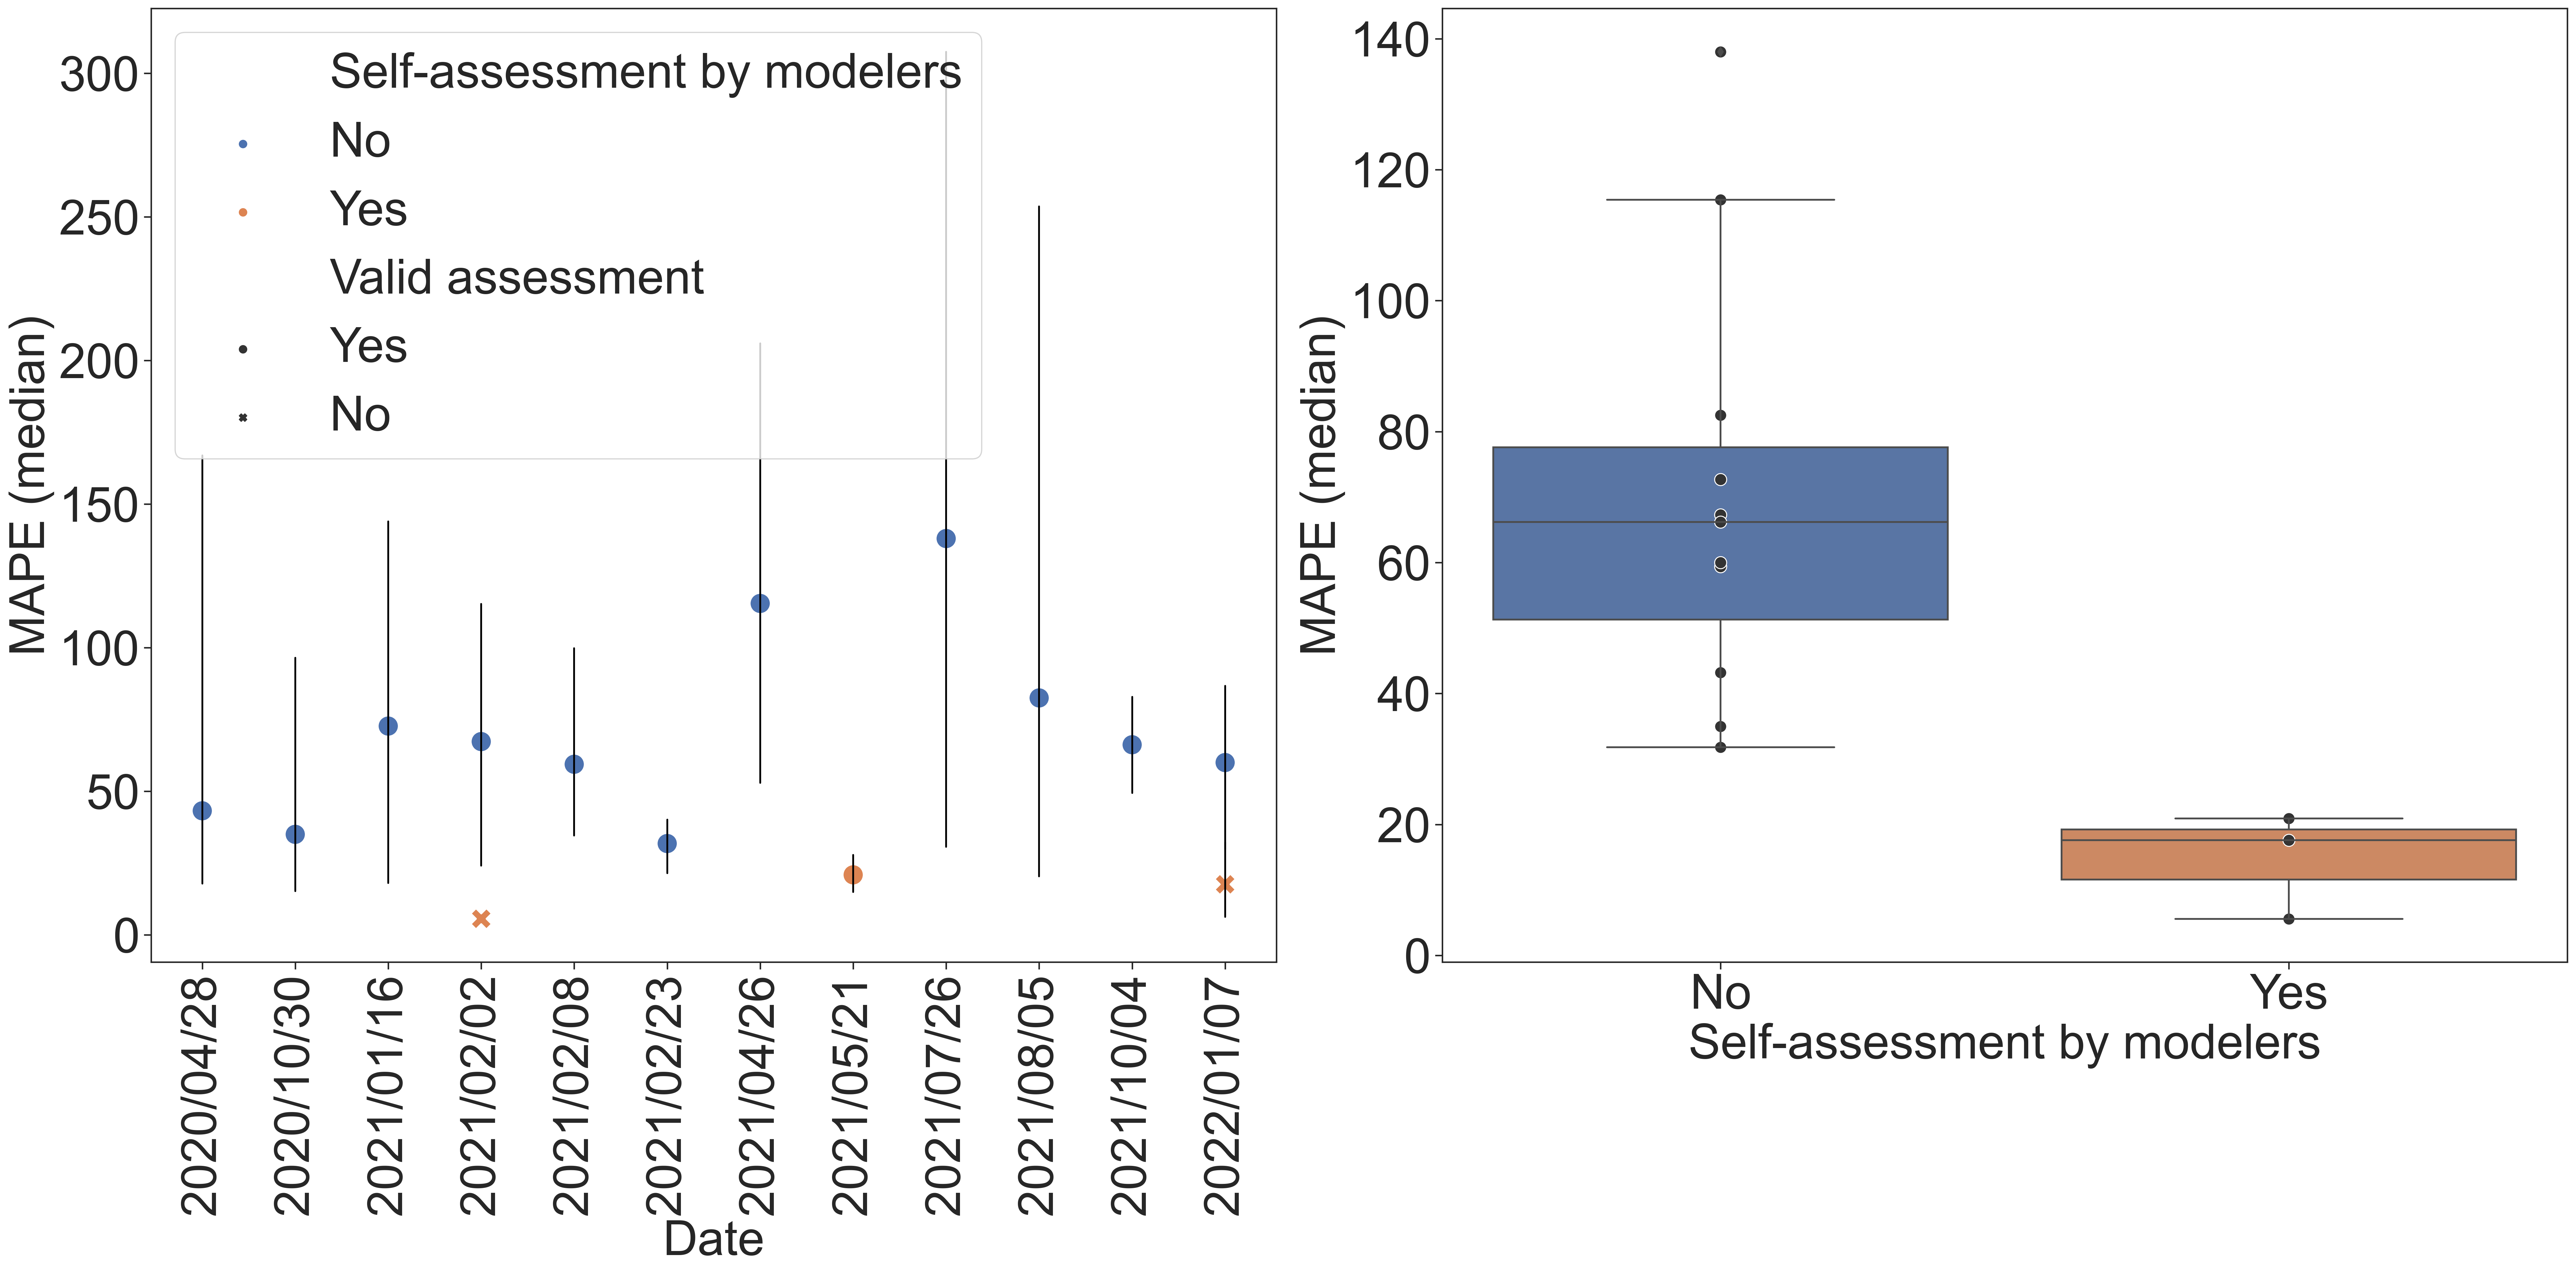

In [ ]:

fig, axes = plt.subplots(figsize=(30, 15), ncols=2, nrows=1)

for index, row in df.iterrows():
    axes[0].plot([row['Date'], row['Date']], [row['MAPE (pessimist)'], row['MAPE (optimist)']], color='black')
g = sns.scatterplot(x="Date", y="MAPE (median)",
             hue="Self-assessment by modelers", style="Valid assessment",
             data=df, ax=axes[0], s=300)
sns.move_legend(g, "upper left")

axes[0].tick_params(axis='x', rotation=90)


h = sns.boxplot(y="MAPE (median)",
             x="Self-assessment by modelers",
             data=df, ax=axes[1])
sns.scatterplot(y="MAPE (median)",
             x="Self-assessment by modelers",
             data=df, ax=axes[1], s=100, color=".2")

plt.tight_layout()

fig_path = images_path + '/self_assessment_bias.pdf'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
